---
title: "SpotOptim Step-by-Step Optimization Process"
author: Bartz-Beielstein, Thomas
date: "November 19, 2025"
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    number-sections: true
jupyter: python3
---

# Introduction

This document provides a comprehensive step-by-step explanation of the optimization process in the `SpotOptim` class. We'll use the 2-dimensional Rosenbrock function as our example and cover all methods involved in each stage of optimization.

**Topics Covered:**

- Standard optimization workflow
- Handling noisy functions with repeats
- Handling function evaluation failures (NaN/inf values)

# Setup and Test Functions

Let's start by defining our test functions, including variants with noise and occasional failures.
The two-dimensional Rosenbrock function is defined as:
$$
f(x, y) = (a - x)^2 + b(y - x^2)^2
$$
where typically \(a = 1\) and \(b = 100\).
The generalized form for n dimensions is:
$$
f(X) = \sum_{i=1}^{N-1} \left[100 \cdot (x_{i+1} - x_i^2)^2 + (1 - x_i)^2\right]
$$
The documentation can be found here: [DOC](https://sequential-parameter-optimization.github.io/spotoptim/reference/spotoptim/function/analytical/#spotoptim.function.analytical.rosenbrock)

In [1]:
import numpy as np
from spotoptim import SpotOptim
from spotoptim.function import rosenbrock
import warnings
warnings.filterwarnings('ignore')

Set random seed for reproducibility:

In [2]:
np.random.seed(42)

Based on the standard Rosenbrock function, we define two variants:

1. the noisy Rosenbrock function:

In [3]:
def rosenbrock_noisy(X, noise_std=0.1):
    """
    Rosenbrock with Gaussian noise for testing noisy optimization.
    """
    X = np.atleast_2d(X)
    base_values = rosenbrock(X)
    noise = np.random.normal(0, noise_std, size=base_values.shape)
    return base_values + noise

and 2. the Rosenbrock function with occasional failures:

In [4]:
def rosenbrock_with_failures(X, failure_prob=0.15):
    """
    Rosenbrock that occasionally returns NaN to simulate evaluation failures.
    """
    X = np.atleast_2d(X)
    values = rosenbrock(X)

    # Randomly inject failures
    for i in range(len(values)):
        if np.random.random() < failure_prob:
            values[i] = np.nan

    return values

# Standard Optimization Workflow

Let's trace through a complete optimization run to understand each step.

## Phase: Initialization and Setup

When you create a `SpotOptim` instance, several initialization steps occur during the `__init__()` method, see [DOC](https://sequential-parameter-optimization.github.io/spotoptim/reference/spotoptim/SpotOptim/#spotoptim.SpotOptim.SpotOptim).

1. Objective function (`fun`) and  bounds are stored.
2. Acquisition function (`acquisition`) is stored (default is `y`).
3. Determine if noise handling is active (based on `repeats_initial` and `repeats_surrogate`)
4. For dimensions with tuple bounds (factor variables), internal integer mappings are created and bounds are replaced with (0, n_levels-1). This is handled by `_process_factor_bounds()`. So, e.g., `[('red', 'green', 'blue')]` is mapped to the  integer interval `[(0, 2)]` internally.
5. The dimension of the problem (`n_dim`) is inferred from the bounds.
6. If `var_type` is not provided, it defaults to all "float" (continuous) variables, except for factor variables which are set to "factor" via `_process_factor_bounds()`.
7. Default variable names (`var_name`) are set if not provided.
8. Default variable transformations (`var_transform`) are set if not provided.
9. Transformations are applied to bounds based on `var_transform` settings. Natural bounds are stored in `_original_lower` and `_original_upper`.
10. Dimension reduction by identifying fixed dimensions (if any) is performed via `_setup_dimension_reduction()`.
11. The surrogate is initialized (default: Gaussian Process with Matérn kernel) as follows:
```python
kernel = ConstantKernel(
    constant_value=1.0, constant_value_bounds=(1e-3, 1e3)
) * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=2.5)
self.surrogate = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=10,
    normalize_y=True,
    random_state=self.seed,
)
```
12. The Design generator is initialized (default: Latin Hypercube Sampling).
13. The storage for results ins initialized. This includes the following attributes:
    - `X_`: Evaluated design points
    - `y_`: Corresponding function values
    - `y_mo`: For multi-objective functions, stores all objectives
    - `best_x_`: Best point found so far
    - `best_y_`: Best function value found so far
    - `n_iter_`: Number of iterations completed
    - `mean_X`, `mean_y`, `var_y`: For noisy functions, mean and variance tracking
    - `min_mean_X`: Best mean point for noisy functions
    - `min_mean_y`: Best mean value for noisy functions
    - `min_var_y`: Variance at best mean point
    - `min_X`: Best point found (deterministic)
    - `min_y`: Best function value found (deterministic)
    - `counter`: Total number of function evaluations
    - `success_rate`: Ratio of successful evaluations
    - `success_counter`: Count of successful evaluations
    - `window_size`: For moving average of success rate
    - `success_history`: History of success/failure for evaluations

In [5]:
# Create optimizer
opt = SpotOptim(
    fun=rosenbrock,
    bounds=[(-2, 2), (1, 2)],
    n_initial=10,
    max_iter=30,
    verbose=True,
    seed=42,
    var_trans=["id", "log"]
)

TensorBoard logging disabled


## Phase: Initial Design Generation

### Method: `get_initial_design()`

This method generates or processes the initial sample points.
It is manually called here for demonstration (normally done inside `optimize()`).

**What happens in `get_initial_design()`:**

1. If `X0=None`: Generate space-filling design using Latin Hypercube Sampling (LHS)
2. If `x0` (starting point) provided: Include it as first point and transform user's points to internal scale
4. Apply dimension reduction if configured
5. Round integer/factor variables

In [6]:
X0 = opt.get_initial_design(X0=None)

print(f"Generated {len(X0)} initial design points using Latin Hypercube Sampling")
print(f"Design shape: {X0.shape}")
print(f"\nFirst 3 points (internal scale):")
print(X0[:3])

Generated 10 initial design points using Latin Hypercube Sampling
Design shape: (10, 2)

First 3 points (internal scale):
[[-1.10958242  0.45478229]
 [ 1.65656083  0.228921  ]
 [-1.63767094  0.55620747]]


Note, because `bounds` were set to `[(-2, 2), (-2, 2)]` and `n_initial=10`, the generated points are within this range and the design has two-dimensional shape (10, 2).

* Print initial design in original scale and in internal scale:

In [7]:
X0_original = opt._inverse_transform_X(X0)
print(f"\nFirst 3 points (original scale):")
print(X0_original[:3])
print(f"\nFirst 3 points (internal scale):")
print(X0[:3])


First 3 points (original scale):
[[-1.10958242  1.57583027]
 [ 1.65656083  1.25724272]
 [-1.63767094  1.7440456 ]]

First 3 points (internal scale):
[[-1.10958242  0.45478229]
 [ 1.65656083  0.228921  ]
 [-1.63767094  0.55620747]]


* Plot initial design in original scale:

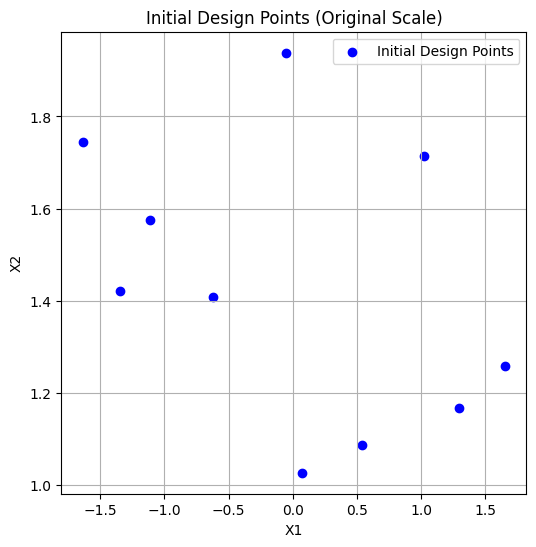

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(X0_original[:, 0], X0_original[:, 1], c='blue', label='Initial Design Points')
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Initial Design Points (Original Scale)")
plt.legend()
plt.grid(True)
plt.show()

## Phase 3: Initial Design Curation

### Method: `_curate_initial_design()`

This method ensures we have sufficient unique points and handles repeats.

**What happens in `_curate_initial_design()`:**

1. Remove duplicate points (can occur after rounding integers)
2. Generate additional points if duplicates reduced count below `n_initial`
3. Repeat each point `repeats_initial` times if > 1 (for noisy functions)

In [9]:
X0_curated = opt._curate_initial_design(X0)
print(f"Curated design shape: {X0_curated.shape}")
print(f"Unique points: {len(np.unique(X0_curated, axis=0))}")
print(f"Total points (with repeats): {len(X0_curated)}")

Curated design shape: (10, 2)
Unique points: 10
Total points (with repeats): 10


## Phase 4: Initial Design Evaluation

### Method: `_evaluate_function()`

Evaluates the objective function at all initial design points.
The points are converted back to the original scale for evaluation.

**What happens in `_evaluate_function()`:**

1. Convert points from internal to original scale
2. Call objective function with batch of points
3. Convert multi-objective to single-objective if needed
4. Return array of function values

In [10]:
X0_original = opt._inverse_transform_X(X0_curated)
y0 = opt._evaluate_function(X0_curated)

print(f"Evaluated {len(y0)} points")
print(f"Function values shape: {y0.shape}")
print(f"First 5 points with function values:")
for i in range(min(5, len(y0))):
    print(f"  Point {i+1}: {X0_original[i]} → f(x)={y0[i]:.6f}")
print(f"\nBest initial value: {np.min(y0):.6f}")
print(f"Worst initial value: {np.max(y0):.6f}")
print(f"Mean initial value: {np.mean(y0):.6f}")

Evaluated 10 points
Function values shape: (10,)
First 5 points with function values:
  Point 1: [-1.10958242  1.57583027] → f(x)=16.329192
  Point 2: [1.65656083 1.25724272] → f(x)=221.533421
  Point 3: [-1.63767094  1.7440456 ] → f(x)=94.926795
  Point 4: [1.29554412 1.1658592 ] → f(x)=26.360696
  Point 5: [-0.05124545  1.93852778] → f(x)=375.876648

Best initial value: 16.329192
Worst initial value: 375.876648
Mean initial value: 107.571208


## Phase 5: Handling Failed Evaluations

### Method: `_handle_NA_initial_design(X0,y0)`

Removes points that returned NaN or inf values.
In contrasts to later phases, no penalties are applied here; invalid points of the initial design are simply removed.

**What happens in `_handle_NA_initial_design()`:**

1. Identify NaN/inf values in function evaluations
2. Remove corresponding design points
3. Return cleaned arrays and original count
4. Note: No penalties applied in initial design - invalid points simply removed

In [11]:
n_before = len(y0)
X0_clean, y0_clean, n_evaluated = opt._handle_NA_initial_design(X0_curated, y0)

print(f"Points before filtering: {n_before}")
print(f"Points after filtering: {len(y0_clean)}")
print(f"Removed: {n_before - len(y0_clean)} NaN/inf values")
print(f"\nAll remaining values finite: {np.all(np.isfinite(y0_clean))}")

Points before filtering: 10
Points after filtering: 10
Removed: 0 NaN/inf values

All remaining values finite: True


## Phase 6: Validation Check

### Method: `_check_size_initial_design(y0, n_evaluated)`

Ensures we have enough valid points to continue.
The minimum required is the smaller of:

* typical minimum for surrogate fitting (3 for multi-dimensional, 2 for 1D), or 
* what the user requested (n_initial).

**What happens in `_check_size_initial_design()`:**

1. Check if at least 1 valid point exists
2. Raise error if all initial evaluations failed
3. Print warnings if many points were invalid

In [12]:
try:
    opt._check_size_initial_design(y0_clean, n_evaluated)
    print(f"✓ Validation passed: {len(y0_clean)} valid points available")
    print(f"  Minimum required: 1 point")
    print(f"  Original evaluated: {n_evaluated} points")
except ValueError as e:
    print(f"✗ Validation failed: {e}")

✓ Validation passed: 10 valid points available
  Minimum required: 1 point
  Original evaluated: 10 points


## Phase 7: Storage Initialization

### Method:  `_init_storage()`

Store evaluated points and initialize tracking variables.

**What happens during storage initialization:**

1. `_init_storage()`: Initialize statistics tracking variables. 


* Initialize storage (as done in `optimize()`)

In [13]:
# Initialize storage and statistics using the new _init_storage() method
opt._init_storage(X0_clean, y0_clean)

print(f"X_ (evaluated points): shape {opt.X_.shape}")
print(f"y_ (function values): shape {opt.y_.shape}")
print(f"n_iter_ (iterations): {opt.n_iter_}")

X_ (evaluated points): shape (10, 2)
y_ (function values): shape (10,)
n_iter_ (iterations): 0


## Phase: Statistics Update

### Method: `update_stats()`

Update statistics like means and variances for noisy evaluations.

*** What happens in `update_stats()`:***

1. If `noise` is set (i.e., `repeats_initial` > 1):
    - Compute mean and variance of function values for each unique point
    - Store in `mean_X`, `mean_y`, and `var_y`


In [14]:
print(f"\nStatistics updated:")
if opt.noise:
    print(f"  - mean_X: {opt.mean_X.shape}")
    print(f"  - mean_y: {opt.mean_y.shape}")
    print(f"  - var_y: {opt.var_y.shape}")
else:
    print(f"  - No noise tracking (repeats=1)")


Statistics updated:
  - No noise tracking (repeats=1)


## Phase: Log initial Design to TensorBoard

### Method: `_log_initial_design_tensorboard()`

This method logs the initial design points and their evaluations to TensorBoard for visualization.



## Phase: Initial Best Point

### Method: `_get_best_xy_initial_design()`

Identify and report the best point from initial design.

**What happens in `_get_best_xy_initial_design()`:**

1. Find minimum value in `y_` (or `mean_y` if noise)
2. Store as `best_y_`
3. Store corresponding point as `best_x_`
4. Print progress if verbose

In [15]:
opt._get_best_xy_initial_design()

print(f"Best point found: {opt.best_x_}")
print(f"Best value found: {opt.best_y_:.6f}")
print(f"\nOptimum location: [1, 1]")
print(f"Optimum value: 0")
print(f"Current gap: {opt.best_y_ - 0:.6f}")

Initial best: f(x) = 16.329192
Best point found: [-1.10958242  1.57583027]
Best value found: 16.329192

Optimum location: [1, 1]
Optimum value: 0
Current gap: 16.329192


## Illustration of the Initial Design Phase Results

To visualize the results, we generate a contour plot with contour lines of the objective function and mark the best point. The other evaluated points are shown as well:

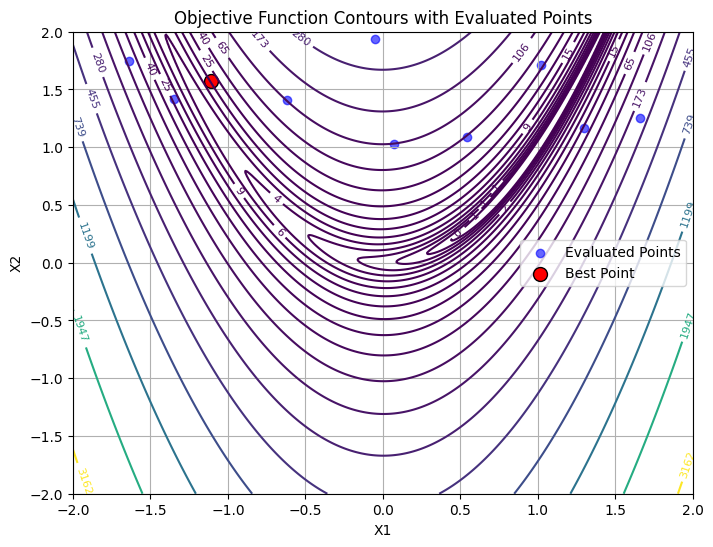

In [16]:
# Create a grid of points for contour plotting
x = np.linspace(-2, 2, 400)
y = np.linspace(-2, 2, 400)
X, Y = np.meshgrid(x, y)
grid_points = np.column_stack([X.ravel(), Y.ravel()])
Z = rosenbrock(grid_points).reshape(X.shape)
plt.figure(figsize=(8, 6))
# Contour plot
contour = plt.contour(X, Y, Z, levels=np.logspace(-0.5, 3.5, 20), cmap='viridis')
plt.clabel(contour, inline=True, fontsize=8)

# Plot evaluated points from the initial design phase:
plt.scatter(opt.X_[:, 0], opt.X_[:, 1], c='blue', label='Evaluated Points', alpha=0.6)
# Mark best point
plt.scatter(opt.best_x_[0], opt.best_x_[1], c='red', s=100, label='Best Point', edgecolors='black')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Objective Function Contours with Evaluated Points')
plt.legend()
plt.grid(True)
plt.show()

# Sequential Optimization Loop

After initialization, the main optimization loop begins. Each iteration follows these steps:

## Step: Surrogate Model Fitting

### Method: `_fit_scheduler()`

Fit surrogate model using appropriate data based on noise handling.

*** What happens in `_fit_scheduler()`:***

First, the method transforms the input data `X` to the internal scale used by the optimizer. Then, it decides which data to use for fitting the surrogate model based on whether noise handling is enabled:

1. If `noise` is set (i.e., `repeats_surrogate` > 1):
    - Fit surrogate using mean points (`mean_X`, `mean_y`)
2. Else:
    - Fit surrogate using all evaluated points (`X_`, `y_`)

`_fit_scheduler()` then calls `_fit_surrogate()` with the selected data.

### Method: `_fit_surrogate()`

Fit a surrogate model (Gaussian Process) to current data.

**What happens in `_fit_surrogate()`:**

1. If `max_surrogate_points` set and exceeded: Select subset of points using the `_selection_dispatcher()` method.
2. Fit surrogate model using `surrogate.fit(X, y)`
3. Surrogate learns the function landscape and uncertainty

In [17]:
X_for_surrogate = opt._transform_X(opt.X_)
opt._fit_surrogate(X_for_surrogate, opt.y_)

print(f"Surrogate fitted with {len(opt.y_)} points")
print(f"Surrogate type: {type(opt.surrogate).__name__}")
print(f"Kernel: {opt.surrogate.kernel_}")

Surrogate fitted with 10 points
Surrogate type: GaussianProcessRegressor
Kernel: 1.06**2 * Matern(length_scale=0.355, nu=2.5)


### Method: `_selection_dispatcher()`

**What happens in `_selection_dispatcher()`:**

1. If `max_surrogate_points` is set and exceeded:
   - Select a subset of points from `X_` and `y_` for fitting the surrogate model.
   - Strategies may include random sampling, clustering, or other heuristics to reduce the dataset size while preserving important information.


**Surrogate Model Selection:**

- Default: Gaussian Process with Matérn kernel
- Provides: Mean prediction $\mu(x)$ and uncertainty $\sigma(x)$
- Can be replaced with Random Forest, Kriging, etc.

* The fitted surrogate can be plotted with the following code:

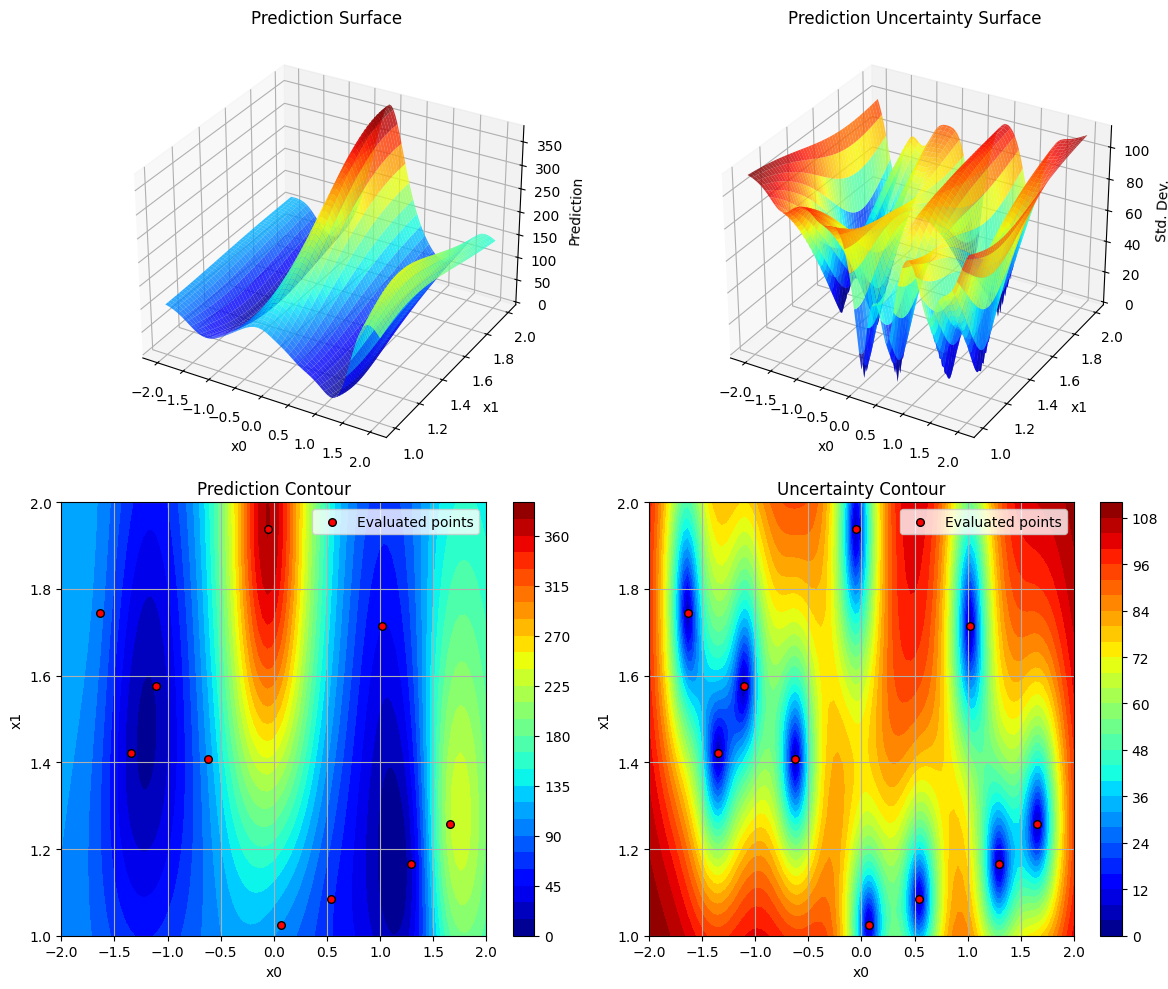

In [18]:
opt.plot_surrogate()

### Step: Apply OCBA

### Method: `_apply_ocba()`

**What happens in `_apply_ocba()`:**

1. Compute the optimality criteria for each point in the design space.
2. Select the most promising points based on the criteria.
3. Update the surrogate model with the selected points.

In [19]:
X_ocba = opt._apply_ocba()
if X_ocba is not None:
    print(f"OCBA selected {X_ocba.shape[0]} points for re-evaluation")
    print(f"OCBA points shape: {X_ocba.shape}")
else:
    print("OCBA not applied (noise=False or ocba_delta=0)")

OCBA not applied (noise=False or ocba_delta=0)


## Step: Predict with Uncertainty

### Method: `_predict_with_uncertainty()`

Make predictions at new locations with uncertainty estimates.


**What happens in `_predict_with_uncertainty()`:**

1. Call `surrogate.predict(X, return_std=True)`
2. Returns mean μ(x) and standard deviation σ(x)
3. Used by acquisition function to balance exploitation (low μ) and exploration (high σ)


Here we test prediction at a few points:

In [20]:
X_test = np.array([[0.5, 0.5], [1.0, 1.0], [-0.5, 0.5]])
mu, sigma = opt._predict_with_uncertainty(X_test)

print(f"Test points: {X_test.shape}")
print(f"\nPredictions (μ ± σ):")
for i, (x, m, s) in enumerate(zip(X_test, mu, sigma)):
    print(f"  x={x} → μ={m:.4f}, σ={s:.4f}")

Test points: (3, 2)

Predictions (μ ± σ):
  x=[0.5 0.5] → μ=135.9904, σ=96.1193
  x=[1. 1.] → μ=97.6979, σ=104.5930
  x=[-0.5  0.5] → μ=169.1890, σ=64.4389


## Step: Next Point Suggestion

### Method: `_suggest_next_point()`

Optimize acquisition function to find next evaluation point.

**What happens in `_suggest_next_point()`:**

1. Use `differential_evolution` to optimize acquisition function
2. Find point that maximizes EI (or minimizes predicted value for 'y')
3. Apply rounding for integer/factor variables
4. Check distance to existing points (avoid duplicates)
5. If duplicate or too close: Use fallback strategy
6. Return suggested point

In [21]:
x_next = opt._suggest_next_point()
print(f"Next point suggested: {x_next}")

Next point suggested: [1.13866324 0.15750508]


Predict at suggested point:

In [22]:
mu_next, sigma_next = opt._predict_with_uncertainty(x_next.reshape(1, -1))
print(f"\nPrediction at suggested point:")
print(f"  μ(x_next) = {mu_next[0]:.4f}")
print(f"  σ(x_next) = {sigma_next[0]:.4f}")


Prediction at suggested point:
  μ(x_next) = 1.3255
  σ(x_next) = 50.4602


**Fallback Strategies** (if acquisition optimization fails):

- `'best'`: Re-evaluate current best point
- `'mean'`: Select point with best predicted mean
- `'random'`: Random point in search space


## Step: Acquisition Function Evaluation

### Method: `_acquisition_function()`

Compute acquisition function value to guide search.
The acquisition function is used as an objective function by the optimizer on the surrogate, e.g., differential evolution. It determines where to sample next.

In [23]:
# Evaluate acquisition at test points
print(f"Acquisition type: {opt.acquisition} (Expected Improvement)")
print(f"\nAcquisition values at test points:")

for x in X_test:
    acq_val = opt._acquisition_function(x)
    print(f"  x={x} → acq={acq_val:.6f}")

Acquisition type: y (Expected Improvement)

Acquisition values at test points:
  x=[0.5 0.5] → acq=135.990446
  x=[1. 1.] → acq=97.697886
  x=[-0.5  0.5] → acq=169.189001


Acquisition function can be used to balance:

* exploitation, i.e., low predicted mean $\mu(x)$ and
* exploration, i.e., high uncertainty $\sigma(x)$


**Acquisition Functions Available:**

1. **Expected Improvement (EI)** - Default, best balance
$$
\text{EI}(x) = (f^* - \mu(x))\Phi(Z) + \sigma(x)\phi(Z)
$$
where $Z = \frac{f^* - \mu(x)}{\sigma(x)}$

2. **Probability of Improvement (PI)** - More exploitative
$$
\text{PI}(x) = \Phi\left(\frac{f^* - \mu(x)}{\sigma(x)}\right)
$$

3. **Mean ('y')** - Pure exploitation
$$
\text{acq}(x) = \mu(x)
$$


## Step: Update Repeats for Infill Points

### Method: `_update_repeats_infill_points()`

Repeat the infill point for noisy function evaluation if `repeats_surrogate > 1`.

**What happens in `_update_repeats_infill_points()`:**

1. Takes the suggested next point (`x_next`)
2. If `repeats_surrogate > 1`: Creates multiple copies for repeated evaluation
3. Otherwise: Returns point as 2D array (shape: 1 × n_features)
4. Returns array ready for function evaluation

In [24]:
x_next_repeated = opt._update_repeats_infill_points(x_next)
print(f"Shape before repeating: {x_next.shape}")
print(f"Shape after repeating: {x_next_repeated.shape}")
print(f"Number of evaluations planned: {x_next_repeated.shape[0]}")

Shape before repeating: (2,)
Shape after repeating: (1, 2)
Number of evaluations planned: 1


## Append OCBA Points to Infill Points

Combines OCBA selected points with the next suggested point for evaluation.

In [25]:
if X_ocba is not None:
    x_next_repeated = np.append(X_ocba, x_next_repeated, axis=0)

## Step: Evaluation of New Points

### Method: `_evaluate_function()` (again)

Evaluate the objective function at the suggested points.

In [26]:
x_next_2d = x_next.reshape(1, -1)
y_next = opt._evaluate_function(x_next_2d)

print(f"Evaluated point: {x_next}")
print(f"Function value: {y_next[0]:.6f}")
print(f"Current best: {opt.best_y_:.6f}")

Evaluated point: [1.13866324 0.15750508]
Function value: 1.606003
Current best: 16.329192


## Step: Handle Failed Evaluations (Sequential)

### Method: `_handle_NA_new_points()`

Handle NaN/inf values in new evaluations with penalty approach.

**What happens in `_handle_NA_new_points()`:**

1. **Apply penalty** to NaN/inf values (unlike initial design)
   - Penalty = max(history) + 3×std(history) + random noise
2. **Remove** remaining invalid values after penalty
3. **Return None** if all evaluations failed → skip iteration
4. **Continue** if any valid evaluations exist

In [27]:
x_clean, y_clean = opt._handle_NA_new_points(x_next_2d, y_next)

if x_clean is not None:
    print(f"✓ Valid evaluations: {len(y_clean)}")
    print(f"  All values finite: {np.all(np.isfinite(y_clean))}")
else:
    print(f"✗ All evaluations failed - iteration would be skipped")

✓ Valid evaluations: 1
  All values finite: True


**Why penalties in sequential phase?**

- Preserves optimization history
- Allows surrogate to learn "bad" regions
- Random noise prevents identical penalties



## Step: Update Success Rate

### Method: `_update_success_rate(y0)`

Update success rate BEFORE updating storage (initial design - all should be successes since starting from scratch)

**What happens in `_update_success_rate()`:**

1. Calculate success rate as ratio of valid evaluations to total evaluated

In [28]:
opt._update_success_rate(y0_clean)
print(f"\nSuccess rate updated: {opt.success_rate:.2%} (valid evaluations / total evaluations)")


Success rate updated: 0.00% (valid evaluations / total evaluations)


## Step: Update Storage

### Internal updates

Add new evaluations to storage.

In [29]:
opt._update_storage(x_next_repeated, y_next)

## Update Statistics

Update statistics after new evaluations.

### What happens in `update_stats()`:

**Always updated:**

- `min_y`: Best (minimum) function value
- `min_X`: Design point with best value
- `counter`: Total number of evaluations

**For noisy functions only (if `noise=True`):**

- `mean_X`: Unique design points
- `mean_y`: Mean values per design point
- `var_y`: Variance per design point

In [30]:
opt.update_stats()
print(f"Basic statistics:")
print(f"  min_y: {opt.min_y:.6f}")
print(f"  min_X: {opt.min_X}")
print(f"  counter: {opt.counter}")

if opt.noise:
    print(f"\nNoise statistics:")
    print(f"  mean_X shape: {opt.mean_X.shape}")
    print(f"  mean_y shape: {opt.mean_y.shape}")
    print(f"  var_y shape: {opt.var_y.shape}")
else:
    print(f"\nNoise handling: disabled (deterministic function)")

Basic statistics:
  min_y: 1.606003
  min_X: [1.13866324 1.1705867 ]
  counter: 11

Noise handling: disabled (deterministic function)


## Step: Update Best Solution

### Method: `_update_best_main_loop()`

Update the best solution if improvement found.

In [31]:
best_before = opt.best_y_
opt._update_best_main_loop(x_clean, y_clean)

print(f"Best before: {best_before:.6f}")
print(f"Best after: {opt.best_y_:.6f}")

if opt.best_y_ < best_before:
    print(f"\n✓ New best found!")
    print(f"  Location: {opt.best_x_}")
    print(f"  Value: {opt.best_y_:.6f}")
else:
    print(f"\n○ Best unchanged")

Iteration 0: New best f(x) = 1.606003
Best before: 16.329192
Best after: 1.606003

✓ New best found!
  Location: [1.13866324 1.1705867 ]
  Value: 1.606003


**Loop Termination Conditions:**

The optimization continues until:

1. `len(y_) >= max_iter` (reached evaluation budget), OR
2. `elapsed_time >= max_time` (reached time limit)

# Complete Optimization Example

Now let's run a complete optimization to see all steps in action:

In [32]:
# Create fresh optimizer
opt_complete = SpotOptim(
    fun=rosenbrock,
    bounds=[(-2, 2), (-2, 2)],
    n_initial=8,
    max_iter=25,
    acquisition='ei',
    verbose=False,  # Set to False for cleaner output
    seed=42
)

# Run optimization
result = opt_complete.optimize()

print(f"\nOptimization Result:")
print(f"{'='*70}")
print(f"Best point found: {result.x}")
print(f"Best value: {result.fun:.6f}")
print(f"True optimum: [1.0, 1.0]")
print(f"True minimum: 0.0")
print(f"Gap to optimum: {result.fun:.6f}")
print(f"\nFunction evaluations: {result.nfev}")
print(f"Sequential iterations: {result.nit}")
print(f"Success: {result.success}")
print(f"Message: {result.message}")


Optimization Result:
Best point found: [1.08776853 1.15560806]
Best value: 0.084058
True optimum: [1.0, 1.0]
True minimum: 0.0
Gap to optimum: 0.084058

Function evaluations: 25
Sequential iterations: 17
Success: True
Message: Optimization terminated: maximum evaluations (25) reached


# Noisy Functions with Repeats

When dealing with noisy objective functions, SpotOptim can evaluate each point multiple times and track statistics.

## Configuration for Noisy Functions

In [33]:
NOISE_STD = 10.0
print("\n" + "="*70)
print("NOISY FUNCTION OPTIMIZATION")
print("="*70)
print(f"\nConfiguration for noisy optimization with noise std = {NOISE_STD}:")


# Wrapper to add noise
def rosenbrock_noisy_wrapper(X):
    return rosenbrock_noisy(X, noise_std=NOISE_STD)

opt_noisy = SpotOptim(
    fun=rosenbrock_noisy_wrapper,
    bounds=[(-2, 2), (-2, 2)],
    n_initial=6,
    max_iter=20,
    repeats_initial=3,      # Evaluate each initial point 3 times
    repeats_surrogate=2,    # Evaluate each sequential point 2 times
    verbose=False,
    seed=42
)

print("Configuration for noisy optimization:")
print(f"  repeats_initial: {opt_noisy.repeats_initial}")
print(f"  repeats_surrogate: {opt_noisy.repeats_surrogate}")
print(f"  noise: {opt_noisy.noise}")


NOISY FUNCTION OPTIMIZATION

Configuration for noisy optimization with noise std = 10.0:
Configuration for noisy optimization:
  repeats_initial: 3
  repeats_surrogate: 2
  noise: True


## Noisy Optimization Workflow Differences

### Modified Initial Design

With `repeats_initial > 1`:

In [34]:
result_noisy = opt_noisy.optimize()

print(f"\nInitial design with repeats:")
print(f"  n_initial = {opt_noisy.n_initial}")
print(f"  repeats_initial = {opt_noisy.repeats_initial}")
print(f"  Total initial evaluations: {opt_noisy.n_initial * opt_noisy.repeats_initial}")

print(f"\nStatistics tracked:")
print(f"  mean_X shape: {opt_noisy.mean_X.shape} (unique points)")
print(f"  mean_y shape: {opt_noisy.mean_y.shape} (mean values)")
print(f"  var_y shape: {opt_noisy.var_y.shape} (variances)")

print(f"\nExample statistics for first point:")
idx = 0
print(f"  Point: {opt_noisy.mean_X[idx]}")
print(f"  Mean value: {opt_noisy.mean_y[idx]:.4f}")
print(f"  Variance: {opt_noisy.var_y[idx]:.4f}")
print(f"  Std dev: {np.sqrt(opt_noisy.var_y[idx]):.4f}")


Initial design with repeats:
  n_initial = 6
  repeats_initial = 3
  Total initial evaluations: 18

Statistics tracked:
  mean_X shape: (7, 2) (unique points)
  mean_y shape: (7,) (mean values)
  var_y shape: (7,) (variances)

Example statistics for first point:
  Point: [-1.90573195 -1.79824535]
  Mean value: 2960.5138
  Variance: 68.6148
  Std dev: 8.2834


**Key Differences with Noise:**

1. **Repeated Evaluations**: Each point evaluated multiple times
2. **Statistics Tracking**:
   - `mean_X`: Unique evaluation locations
   - `mean_y`: Mean function values at each location
   - `var_y`: Variance of function values
   - `n_eval`: Number of evaluations per location
3. **Surrogate Fitting**: Uses `mean_y` instead of `y_`
4. **Best Selection**: Based on `mean_y` not individual `y_`

### Update Statistics Method

In [35]:
print(f"After optimization:")
print(f"  Total evaluations: {len(opt_noisy.y_)}")
print(f"  Unique points: {len(opt_noisy.mean_X)}")
print(f"  Average repeats per point: {len(opt_noisy.y_) / len(opt_noisy.mean_X):.2f}")

print(f"\nVariance statistics:")
print(f"  Mean variance: {np.mean(opt_noisy.var_y):.6f}")
print(f"  Max variance: {np.max(opt_noisy.var_y):.6f}")
print(f"  Min variance: {np.min(opt_noisy.var_y):.6f}")

After optimization:
  Total evaluations: 20
  Unique points: 7
  Average repeats per point: 2.86

Variance statistics:
  Mean variance: 43.630970
  Max variance: 94.990756
  Min variance: 6.357449


# Optimal Computing Budget Allocation (OCBA)

OCBA intelligently allocates additional evaluations to distinguish between competing solutions.

## OCBA Configuration

In [36]:
print("\n" + "="*70)
print("OPTIMAL COMPUTING BUDGET ALLOCATION (OCBA)")
print("="*70)

opt_ocba = SpotOptim(
    fun=rosenbrock_noisy_wrapper,
    bounds=[(-2, 2), (-2, 2)],
    n_initial=8,
    max_iter=30,
    repeats_initial=2,
    repeats_surrogate=1,
    ocba_delta=3,           # Allocate 3 additional evaluations per iteration
    verbose=False,
    seed=42
)

print("OCBA Configuration:")
print(f"  ocba_delta: {opt_ocba.ocba_delta}")
print(f"  Purpose: Intelligently re-evaluate existing points")
print(f"  Benefit: Better distinguish between similar solutions")


OPTIMAL COMPUTING BUDGET ALLOCATION (OCBA)
OCBA Configuration:
  ocba_delta: 3
  Purpose: Intelligently re-evaluate existing points
  Benefit: Better distinguish between similar solutions


## OCBA Method

### Method: `_apply_ocba()`

In [37]:
result_ocba = opt_ocba.optimize()

print(f"\nOCBA applied during optimization")
print(f"  Final total evaluations: {result_ocba.nfev}")
print(f"  Expected without OCBA: ~{opt_ocba.n_initial * opt_ocba.repeats_initial + result_ocba.nit * opt_ocba.repeats_surrogate}")
print(f"  Additional OCBA evaluations: ~{result_ocba.nit * opt_ocba.ocba_delta}")

print(f"\nOCBA intelligently allocated extra evaluations to:")
print(f"  - Current best candidate (confirm it's truly best)")
print(f"  - Close competitors (distinguish between similar solutions)")
print(f"  - High-variance points (reduce uncertainty)")


OCBA applied during optimization
  Final total evaluations: 30
  Expected without OCBA: ~27
  Additional OCBA evaluations: ~33

OCBA intelligently allocated extra evaluations to:
  - Current best candidate (confirm it's truly best)
  - Close competitors (distinguish between similar solutions)
  - High-variance points (reduce uncertainty)


**OCBA Algorithm:**

1. Identify best solution (lowest mean value)
2. Calculate allocation ratios based on:
   - Distance to best solution
   - Variance of each solution
3. Allocate `ocba_delta` additional evaluations
4. Returns points to re-evaluate
5. Requires: ≥3 points with variance > 0

**OCBA Activation Conditions:**
- `noise = True` (repeats > 1)
- `ocba_delta > 0`
- At least 3 design points exist
- All points have variance > 0

# Handling Function Evaluation Failures

SpotOptim robustly handles functions that occasionally fail (return NaN/inf).

## Example with Failures

In [38]:
opt_failures = SpotOptim(
    fun=rosenbrock_with_failures,
    bounds=[(-2, 2), (-2, 2)],
    n_initial=12,
    max_iter=35,
    verbose=False,
    seed=42
)

result_failures = opt_failures.optimize()

print(f"\nOptimization with ~15% random failure rate:")
print(f"  Function evaluations: {result_failures.nfev}")
print(f"  Sequential iterations: {result_failures.nit}")
print(f"  Success: {result_failures.success}")

# Count how many values are non-finite in raw evaluations
n_total = len(opt_failures.y_)
n_finite = np.sum(np.isfinite(opt_failures.y_))
print(f"\nEvaluation statistics:")
print(f"  Total evaluations: {n_total}")
print(f"  Finite values: {n_finite}")
print(f"  Note: Failed evaluations handled transparently")


Optimization with ~15% random failure rate:
  Function evaluations: 35
  Sequential iterations: 27
  Success: True

Evaluation statistics:
  Total evaluations: 35
  Finite values: 35
  Note: Failed evaluations handled transparently


## Failure Handling in Initial Design

### Method: `_handle_NA_initial_design()`

In [39]:
print("Initial design failure handling:")
print("  1. Identify NaN/inf values")
print("  2. Remove invalid points entirely")
print("  3. Continue with valid points only")
print("  4. No penalties applied")
print("  5. Require at least 1 valid point")

print("\nRationale:")
print("  - Initial design should be clean")
print("  - Invalid regions identified naturally")
print("  - Surrogate trained on good data only")

Initial design failure handling:
  1. Identify NaN/inf values
  2. Remove invalid points entirely
  3. Continue with valid points only
  4. No penalties applied
  5. Require at least 1 valid point

Rationale:
  - Initial design should be clean
  - Invalid regions identified naturally
  - Surrogate trained on good data only


## Failure Handling in Sequential Phase

### Method: `_handle_NA_new_points()`

In [40]:
print("Sequential phase failure handling:")
print("  1. Apply penalty to NaN/inf values")
print("     - Penalty = max(history) + 3×std(history)")
print("     - Add random noise to avoid duplicates")
print("  2. Remove remaining invalid values")
print("  3. Skip iteration if all evaluations failed")
print("  4. Continue if any valid evaluations")

print("\nPenalty approach benefits:")
print("  ✓ Preserves optimization history")
print("  ✓ Surrogate learns to avoid bad regions")
print("  ✓ Better exploration-exploitation balance")
print("  ✓ More robust convergence")

Sequential phase failure handling:
  1. Apply penalty to NaN/inf values
     - Penalty = max(history) + 3×std(history)
     - Add random noise to avoid duplicates
  2. Remove remaining invalid values
  3. Skip iteration if all evaluations failed
  4. Continue if any valid evaluations

Penalty approach benefits:
  ✓ Preserves optimization history
  ✓ Surrogate learns to avoid bad regions
  ✓ Better exploration-exploitation balance
  ✓ More robust convergence


## Penalty Application

### Method: `_apply_penalty_NA()`

Let's demonstrate penalty calculation:

In [41]:
# Simulate historical values
y_history_sim = np.array([10.0, 15.0, 8.0, 12.0, 20.0, 9.0])
y_new_sim = np.array([7.0, np.nan, 11.0, np.inf])

print("Historical values:", y_history_sim)
print("New evaluations:", y_new_sim)

# Apply penalty
y_repaired = opt_failures._apply_penalty_NA(
    y_new_sim, 
    y_history=y_history_sim,
    penalty_value=None,  # Compute adaptively
    sd=0.1
)

print(f"\nAfter penalty application:", y_repaired)
print(f"All finite: {np.all(np.isfinite(y_repaired))}")

# Show penalty calculation
max_hist = np.max(y_history_sim)
std_hist = np.std(y_history_sim, ddof=1)
penalty_base = max_hist + 3 * std_hist

print(f"\nPenalty calculation:")
print(f"  max(history) = {max_hist:.2f}")
print(f"  std(history) = {std_hist:.2f}")
print(f"  Base penalty = {max_hist:.2f} + 3×{std_hist:.2f} = {penalty_base:.2f}")
print(f"  Actual penalty = {penalty_base:.2f} + noise")

Historical values: [10. 15.  8. 12. 20.  9.]
New evaluations: [ 7. nan 11. inf]

After penalty application: [ 7.         33.62137308 11.         33.5370057 ]
All finite: True

Penalty calculation:
  max(history) = 20.00
  std(history) = 4.50
  Base penalty = 20.00 + 3×4.50 = 33.51
  Actual penalty = 33.51 + noise


# Complete Method Summary

## Methods Called During `optimize()`

### Preparation Phase
1. `get_initial_design()` - Generate/process initial sample points
2. `_curate_initial_design()` - Remove duplicates, handle repeats
3. `_evaluate_function()` - Evaluate objective function
4. `_handle_NA_initial_design()` - Remove NaN/inf from initial design
5. `_check_size_initial_design()` - Validate sufficient points
6. `_init_storage()` - Initialize storage (X_, y_, n_iter_)
7. `update_stats()` - Compute mean/variance for noisy functions
8. `_init_tensorboard()` - Log initial design to TensorBoard (if enabled)
9. `_get_best_xy_initial_design()` - Identify initial best

### Sequential Optimization Loop (each iteration)
10. `_fit_scheduler()` - Select data and fit surrogate based on noise handling
    - Internally calls `_transform_X()` - Transform to internal scale
    - Internally calls `_fit_surrogate()` - Fit Gaussian Process to data
11. `_apply_ocba()` - OCBA allocation (if enabled)
12. `_suggest_next_point()` - Optimize acquisition function
    - Internally calls `_acquisition_function()`
    - Internally calls `_predict_with_uncertainty()`
13. `_update_repeats_infill_points()` - Repeat suggested point for noisy functions
14. `_evaluate_function()` - Evaluate at suggested point(s)
15. `_handle_NA_new_points()` - Handle failures with penalties
    - Internally calls `_apply_penalty_NA()`
    - Internally calls `_remove_nan()`
16. `_update_success_rate()` - Update success tracking
17. `_update_storage()` - Append new evaluations to storage
    - Internally calls `_inverse_transform_X()` - Convert back to original scale
18. `update_stats()` - Update mean/variance statistics
19. `_write_tensorboard_hparams()` - Log hyperparameters (if enabled)
20. `_write_tensorboard_scalars()` - Log scalar metrics (if enabled)
21. `_update_best_main_loop()` - Update best solution

### Finalization
22. `to_all_dim()` - Expand to full dimensions (if dimensionality reduction used)
23. `_determine_termination()` - Determine termination reason
24. `_close_tensorboard_writer()` - Close logging (if enabled)
25. `_map_to_factor_values()` - Convert factors back to strings
26. Return `OptimizeResult` object

## Helper Methods Used

- `_generate_initial_design()` - LHS generation
- `_repair_non_numeric()` - Round integer/factor variables
- `_select_new()` - Check for duplicate points
- `_handle_acquisition_failure()` - Fallback strategies
- `to_red_dim()` - Dimension reduction (if enabled)
- `_selection_dispatcher()` - Subset selection for large datasets

# Termination Conditions

## Method: `_determine_termination()`

In [42]:
print("\n" + "="*70)
print("TERMINATION CONDITIONS")
print("="*70)
print("\nMethod: _determine_termination()")
print("-" * 70)

print("Optimization terminates when:")
print("  1. len(y_) >= max_iter (evaluation budget exhausted)")
print("  2. elapsed_time >= max_time (time limit reached)")
print("  3. Whichever comes first")

print(f"\nExample from previous run:")
print(f"  Message: {result_failures.message}")
print(f"  Evaluations: {result_failures.nfev}/{opt_failures.max_iter}")
print(f"  Iterations: {result_failures.nit}")


TERMINATION CONDITIONS

Method: _determine_termination()
----------------------------------------------------------------------
Optimization terminates when:
  1. len(y_) >= max_iter (evaluation budget exhausted)
  2. elapsed_time >= max_time (time limit reached)
  3. Whichever comes first

Example from previous run:
  Message: Optimization terminated: maximum evaluations (35) reached
  Evaluations: 35/35
  Iterations: 27


# Performance Comparison on Noisy Functions

Let's compare standard, noisy, and noisy+OCBA optimization:

In [43]:
print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)

# Standard optimization
opt_std = SpotOptim(
    fun=rosenbrock_noisy_wrapper,
    bounds=[(-2, 2), (-2, 2)],
    n_initial=8,
    max_iter=50,
    repeats_initial=1,
    repeats_surrogate=1,
    verbose=False,
    seed=10
)
result_std = opt_std.optimize()

# With repeats (no OCBA)
opt_rep = SpotOptim(
    fun=rosenbrock_noisy_wrapper,
    bounds=[(-2, 2), (-2, 2)],
    n_initial=8,
    max_iter=50,
    repeats_initial=2,
    repeats_surrogate=1,
    ocba_delta=0,
    verbose=False,
    seed=10
)
result_rep = opt_rep.optimize()

# With repeats + OCBA
opt_ocba_comp = SpotOptim(
    fun=rosenbrock_noisy_wrapper,
    bounds=[(-2, 2), (-2, 2)],
    n_initial=8,
    max_iter=50,
    repeats_initial=1,
    repeats_surrogate=1,
    ocba_delta=1,
    verbose=False,
    seed=10
)
result_ocba_comp = opt_ocba_comp.optimize()

# Evaluate the found optima with the TRUE (noise-free) Rosenbrock function
# to get the actual quality of the solutions
print(f"\n" + "="*70)
print("TRUE FUNCTION VALUE EVALUATION")
print("="*70)
print("\nRe-evaluating found optima with noise-free Rosenbrock function:")
print("-" * 70)

# Evaluate each solution with the TRUE function (no noise)
true_val_std = rosenbrock(result_std.x.reshape(1, -1))[0]
true_val_rep = rosenbrock(result_rep.x.reshape(1, -1))[0]
true_val_ocba = rosenbrock(result_ocba_comp.x.reshape(1, -1))[0]

print(f"\nStandard (no repeats):")
print(f"  Found x: {result_std.x}")
print(f"  Noisy value (from optimization): {result_std.fun:.6f}")
print(f"  TRUE value (noise-free): {true_val_std:.6f}")

print(f"\nWith repeats (no OCBA):")
print(f"  Found x: {result_rep.x}")
print(f"  Noisy value (from optimization): {result_rep.fun:.6f}")
print(f"  TRUE value (noise-free): {true_val_rep:.6f}")

print(f"\nWith repeats + OCBA:")
print(f"  Found x: {result_ocba_comp.x}")
print(f"  Noisy value (from optimization): {result_ocba_comp.fun:.6f}")
print(f"  TRUE value (noise-free): {true_val_ocba:.6f}")

print(f"\n" + "="*70)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*70)
print(f"\nComparison on noisy Rosenbrock (σ={NOISE_STD}):")
print(f"{'Method':<30} {'Noisy Value':<15} {'TRUE Value':<15} {'Evaluations':<15}")
print(f"{'-'*75}")
print(f"{'Standard (no repeats)':<30} {result_std.fun:<15.6f} {true_val_std:<15.6f} {result_std.nfev:<15}")
print(f"{'With repeats (no OCBA)':<30} {result_rep.fun:<15.6f} {true_val_rep:<15.6f} {result_rep.nfev:<15}")
print(f"{'With repeats + OCBA':<30} {result_ocba_comp.fun:<15.6f} {true_val_ocba:<15.6f} {result_ocba_comp.nfev:<15}")
print(f"{'-'*75}")
print(f"{'True optimum':<30} {'0.0':<15} {'0.0':<15}")

print("\nKey observations:")
print("  • Noisy values (from optimization) are misleading due to noise")
print("  • TRUE values show actual solution quality")
print("  • Repeats help find better solutions despite noise")
print("  • OCBA focuses evaluations on distinguishing best solutions")
print("  • More evaluations generally lead to better TRUE performance")


PERFORMANCE COMPARISON

TRUE FUNCTION VALUE EVALUATION

Re-evaluating found optima with noise-free Rosenbrock function:
----------------------------------------------------------------------

Standard (no repeats):
  Found x: [-0.02303646 -0.12724366]
  Noisy value (from optimization): -14.055814
  TRUE value (noise-free): 2.679232

With repeats (no OCBA):
  Found x: [-0.18461315  0.02269759]
  Noisy value (from optimization): -12.282442
  TRUE value (noise-free): 1.416269

With repeats + OCBA:
  Found x: [-0.06714099 -0.03562667]
  Noisy value (from optimization): -16.585097
  TRUE value (noise-free): 1.299868

PERFORMANCE COMPARISON SUMMARY

Comparison on noisy Rosenbrock (σ=10.0):
Method                         Noisy Value     TRUE Value      Evaluations    
---------------------------------------------------------------------------
Standard (no repeats)          -14.055814      2.679232        50             
With repeats (no OCBA)         -12.282442      1.416269        50       

# Summary

## Complete Workflow Diagram

```
┌─────────────────────────────────────────────────────────────────┐
│                     SPOTOPTIM WORKFLOW                          │
└─────────────────────────────────────────────────────────────────┘

INITIALIZATION PHASE
  │
  ├─► get_initial_design()
  │     └─► Generate LHS or process user design
  │
  ├─► _curate_initial_design()
  │     └─► Remove duplicates, add repeats
  │
  ├─► _evaluate_function()
  │     └─► Evaluate objective function
  │
  ├─► _handle_NA_initial_design()
  │     └─► Remove NaN/inf points
  │
  ├─► _check_size_initial_design()
  │     └─► Validate sufficient points
  │
  ├─► _init_storage()
  │     └─► Initialize X_, y_, n_iter_
  │
  ├─► update_stats()
  │     └─► Compute mean/variance (if noise)
  │
  ├─► _init_tensorboard() [if enabled]
  │     └─► Log initial design to TensorBoard
  │
  └─► _get_best_xy_initial_design()
        └─► Identify initial best


SEQUENTIAL OPTIMIZATION LOOP (until max_iter or max_time)
  │
  ├─► _fit_scheduler()
  │     ├─► _transform_X() - Transform to internal scale
  │     └─► _fit_surrogate() - Fit GP to current data
  │
  ├─► _apply_ocba() [if enabled]
  │     └─► Allocate additional evaluations
  │
  ├─► _suggest_next_point()
  │     ├─► _acquisition_function()
  │     │     └─► _predict_with_uncertainty()
  │     └─► Optimize to find next point
  │
  ├─► _update_repeats_infill_points()
  │     └─► Repeat point if repeats_surrogate > 1
  │
  ├─► _evaluate_function()
  │     └─► Evaluate at suggested point(s)
  │
  ├─► _handle_NA_new_points()
  │     ├─► _apply_penalty_NA()
  │     └─► _remove_nan()
  │
  ├─► _update_success_rate()
  │     └─► Track evaluation success
  │
  ├─► _update_storage()
  │     └─► Append new evaluations (with scale conversion)
  │
  ├─► update_stats()
  │     └─► Update mean/variance
  │
  ├─► _write_tensorboard_hparams() [if enabled]
  │     └─► Log hyperparameters
  │
  ├─► _write_tensorboard_scalars() [if enabled]
  │     └─► Log scalar metrics
  │
  └─► _update_best_main_loop()
        └─► Update best if improved


FINALIZATION
  │
  ├─► to_all_dim() [if dimensionality reduction used]
  │     └─► Expand to full dimensions
  │
  ├─► _determine_termination()
  │     └─► Set termination message
  │
  ├─► _close_tensorboard_writer() [if enabled]
  │     └─► Close TensorBoard logging
  │
  ├─► _map_to_factor_values() [if factors used]
  │     └─► Convert factors back to strings
  │
  └─► Return OptimizeResult
```

## Key Concepts

### 1. Initial Design
- **Latin Hypercube Sampling**: Space-filling design for efficient exploration
- **Curation**: Remove duplicates from integer/factor rounding
- **Failure Handling**: Remove invalid points, no penalties

### 2. Surrogate Model
- **Default**: Gaussian Process with Matérn kernel
- **Provides**: Mean μ(x) and uncertainty σ(x) predictions
- **Purpose**: Learn function landscape with limited evaluations

### 3. Acquisition Function
- **EI**: Expected Improvement (default) - best balance
- **PI**: Probability of Improvement - more exploitative
- **Mean**: Pure exploitation of surrogate predictions

### 4. Noise Handling
- **Repeats**: Evaluate each point multiple times
- **Statistics**: Track mean and variance
- **OCBA**: Intelligently allocate additional evaluations

### 5. Failure Handling
- **Initial Phase**: Remove invalid points
- **Sequential Phase**: Apply adaptive penalties with noise
- **Robustness**: Continue optimization despite failures

## Best Practices

1. **For deterministic functions**:
   - Use default settings (no repeats)
   - Acquisition = 'ei'
   - Focus on n_initial and max_iter

2. **For noisy functions**:
   - Set repeats_initial ≥ 2
   - Set repeats_surrogate ≥ 1
   - Consider OCBA with ocba_delta ≥ 2

3. **For unreliable functions**:
   - SpotOptim handles failures automatically
   - No special configuration needed
   - Penalties guide search away from bad regions

4. **For expensive functions**:
   - Increase n_initial (better initial model)
   - Use 'ei' acquisition (best sample efficiency)
   - Consider max_time limit

## Conclusion

SpotOptim provides a robust and flexible framework for surrogate-based optimization with:

✓ Efficient space-filling initial designs (LHS)  
✓ Powerful Gaussian Process surrogate models  
✓ Smart acquisition functions (EI, PI, Mean)  
✓ Automatic noise handling with statistics  
✓ Intelligent budget allocation (OCBA)  
✓ Robust failure handling  
✓ Comprehensive progress tracking

The modular design allows easy customization while maintaining robust defaults for most use cases.